# Notebook to analyse the ROMS output produced in November 2022

Some information about this ROMS run:
- forced using SODA3.4.2 reanalysis input
- ROMS extent is 36°N to 62°N and -20°W to 10°E
- ROMS resolution is 1/4°x1/4°


There is a ROMS run without spinup (nospinup) and a ROMS run with 3x10years spinup (spinup).

ROMS output is compared to:
- SODA reanalysis data
- SODA forcing data


We look at
Sea level
- regional average
- along the Dutch coast
- mean dynamic topography (MDT) and variability





Processing steps taken:
- Regrid on ROMS output grid
- Obtain annual averages

In [86]:
import xarray as xr
import pandas as pd
import xesmf as xe
import numpy as np

import matplotlib.pyplot as plt

path_fig = '/Users/iriskeizer/Documents/ROMS/figures/SODA/nov_2022'

## Import data

### Import ROMS output

In [87]:
path = '/Users/iriskeizer/Documents/ROMS/data'

In [88]:
roms_nospinup = xr.open_dataset(f'{path}/ROMS output/SODA/23nov/nospinup/NorthSea4_avg_run5_annual.nc')
roms_spinup_run1 = xr.open_dataset(f'{path}/ROMS output/SODA/23nov/spinup/NorthSea4_avg_run1_annual.nc')
roms_spinup_run2 = xr.open_dataset(f'{path}/ROMS output/SODA/23nov/spinup/NorthSea4_avg_run2_annual.nc')
roms_spinup_run3 = xr.open_dataset(f'{path}/ROMS output/SODA/23nov/spinup/NorthSea4_avg_run3_annual.nc')
roms_spinup_run4 = xr.open_dataset(f'{path}/ROMS output/SODA/23nov/spinup/NorthSea4_avg_run4_annual.nc')
roms_ora = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/ORA/run3/annual/NorthSea4_avg_annual.nc')

### Import comparison data

In [89]:
# Import soda reanalysis data
soda = xr.open_dataset(f'{path}/SODA/processed/soda.nc')

In [90]:
# Import climatology forcing obtained from SODA reanalysis data
soda_clim_forc = xr.open_dataset(f'{path}/lateral forcing/NorthSea4 SODA/NorthSea4_clim_SODA_1980116_to_20201216.nc')

In [91]:
# Import AVISO altimetry data
aviso_altimetry = xr.open_dataset(f'{path}/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')


In [92]:
# Import CNES mdt data
cnes_mdt = xr.open_dataset(f'{path}/CNES MDT/dataset-mdt-cnes-cls18-global_1660042875042.nc')

In [93]:
# Import zeespiegel budget data

slbudget_2021 = pd.read_csv(f'{path}/budget/slbudget_2021_12_13_NS_Fred16_1950_2020_ERA5_StericIAP_1100m.csv',
                           index_col = 'time')
slbudget_2022 = pd.read_csv(f'{path}/budget/slbudget_2022_06_14_ZSM_1950_2020_ERA5_StericIAP_2000m.csv',
                           index_col = 'time')

## Data processing

### Obtain annual averages

For the ROMS output (5days averages) the annual averages are already obtained on the Snellius server before the data is downloaded.
The soda reanalysis data and aviso altimetry is monthly.

In [94]:
soda = soda.groupby('time.year').mean('time')

In [95]:
soda_clim_forc = soda_clim_forc.groupby('ocean_time.year').mean('ocean_time').rename({'year':'time'})

In [96]:
aviso_altimetry = aviso_altimetry.groupby('time.year').mean('time')

In [97]:
roms_ora = roms_ora.groupby('ocean_time.year').mean('ocean_time').rename({'year':'time'})

# Drop start of time series
roms_ora = roms_ora.where(roms_ora.time >= 1970, drop = True)

## Regrid data

All data is regridded on the ROMS output grid. 
- The ROMS output itself is first transformed to latitude, longitude grid
- All other data sets are regridded on this ROMS latitude, longitude grid

### Create new dataset for ROMS sea level

In [98]:
def roms_to_latlon(data):
    '''
    Function to obtain a new dataset for the roms data where dimensions are latitude and longitude 
    data should be the ROMS output dataset 
    '''
    
    data_vars = dict(zeta=(["time", "latitude", "longitude"], data.zeta.values),)
        
    coords = dict(time=(["time"], data.time.values),
             latitude=(["latitude"], data.lat_rho.values[:,0]),
             longitude=(["longitude"], data.lon_rho.values[0]))
    
    return xr.Dataset(data_vars = data_vars, coords = coords)
    

In [99]:
roms_nospinup_zeta = roms_to_latlon(roms_nospinup)
roms_spinup_run1_zeta = roms_to_latlon(roms_spinup_run1)
roms_spinup_run2_zeta = roms_to_latlon(roms_spinup_run2)
roms_spinup_run3_zeta = roms_to_latlon(roms_spinup_run3)
roms_spinup_run4_zeta = roms_to_latlon(roms_spinup_run4)
roms_ora_zeta = roms_to_latlon(roms_ora)

In [100]:
def roms_to_latlon(data):
    '''
    Function to obtain a new dataset for the roms data where dimensions are latitude and longitude 
    data should be the ROMS output dataset 
    '''
    
    data_vars = dict(zeta=(["time", "latitude", "longitude"], data.zeta.values),)
        
    coords = dict(time=(["time"], data.time.values),
             latitude=(["latitude"], data.lat_rho.values[0,:,0]),
             longitude=(["longitude"], data.lon_rho.values[0,0]))
    
    return xr.Dataset(data_vars = data_vars, coords = coords)
    

In [101]:
soda_clim_forc_zeta = roms_to_latlon(soda_clim_forc)

### Rename variables and dimensions

In [102]:
soda = soda.drop(['thetao', 'so', 'uo', 'vo', 'xu_ocean', 'yu_ocean', 'depth']).rename({'year':'time', 'yt_ocean':'latitude', 'xt_ocean':'longitude'})

In [103]:
aviso_altimetry = aviso_altimetry.drop(['crs']).rename({'year':'time'})

In [104]:
cnes_mdt = cnes_mdt.drop(['err_mdt'])

### Regrid datasets

In [105]:
roms_input = roms_spinup_run1_zeta

def regrid(input_data, roms_data, sl_var):
    '''
    Function to regrid datasets onto the ROMS 1/4° grid. 
    input_data should be the data that needs to be regridded
    roms_data should be the data whereon the input_data will be regriddedn
    sl_var should be the name for sea level variable in the input_data 
    '''
    
    # Sort coordinates in increasing order
    input_data = input_data.sortby(['latitude', 'longitude'])
    
    # Transpose dimensions
    input_data = input_data.transpose('time', 'latitude', 'longitude')
    
    # Make arrays C_CONTIGUOUS
    roms_data = roms_data.astype(dtype = 'float32', order = 'C')
    input_data[sl_var] = input_data[sl_var].astype(dtype = 'float32', order = 'C')
    
    # Add mask
    input_data['mask'] = xr.where(~np.isnan(input_data[sl_var].isel(time=0)), 1, 0)
    roms_data['mask'] = xr.where(~np.isnan(roms_data.zeta.isel(time=0)), 1, 0)
    
    # Build regridder
    regridder = xe.Regridder(input_data, roms_data, "bilinear", extrap_method= 'nearest_s2d')
    
    # Apply to data
    regridded_data = regridder(input_data)
    
    # Drop mask
    regridded_data = regridded_data.drop(['mask'])
    
    return regridded_data

In [106]:
soda = regrid(soda, roms_input, 'zos')

In [107]:
aviso_altimetry = regrid(aviso_altimetry, roms_input, 'adt')

In [108]:
cnes_mdt = regrid(cnes_mdt, roms_input, 'mdt')

## Compare annual regional mean sea level anomalies for NWES

The ROMS output is compared to the SODA reanalysis, climatological forcing from SODA and AVISO altimetry

### Substract time mean to obtain anomalies

In [73]:
def figure_annual_regional_mean_spinup_nospinup(data_lst, var_lst, labels):
    '''
    Function to obtain the weighted regional mean of data and plot this.
    
    data_lst should be a list containing the data that should be plotted
    var_lst should be a list containing the variable names for the sea level variable
    labels should be a list of the data's names for the legend
    
    '''
    
    weights = np.cos(np.deg2rad(data_lst[0].latitude))
    
    data_averaged = []
    for i, data in enumerate(data_lst):
        weighted = data.weighted(weights)                                      # Obtain weights
        averaged = weighted.mean(['latitude', 'longitude'])                    # Obtain area average
        data_averaged.append(averaged[var_lst[i]] - averaged[var_lst[i]].where(averaged.time <= 1990, drop = True).mean('time'))   # Obtain anomalies
    
    
    # Plot data
    plt.figure(figsize = (7,3))
    for data in data_averaged:
        plt.plot(data.time, data*100)
        
    fsize = 12
    plt.xlabel('Time [yr]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Annual sea level anomalies averaged over NWES area', fontsize = fsize)
    plt.xticks(range(1980, 2021, 10), fontsize = fsize-2)
    plt.yticks(fontsize = fsize-2)
    plt.grid()
    
    plt.legend(labels = labels, fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    
    plt.savefig(f'{path_fig}/annual_regional_mean_spinup_nospinup')

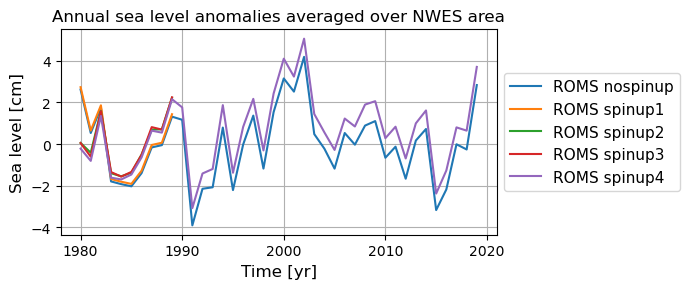

In [74]:
data_lst = [roms_nospinup_zeta, roms_spinup_run1_zeta, roms_spinup_run2_zeta, roms_spinup_run3_zeta, roms_spinup_run4_zeta]
var_lst = ['zeta', 'zeta', 'zeta', 'zeta', 'zeta']
labels = ['ROMS nospinup', 'ROMS spinup1', 'ROMS spinup2', 'ROMS spinup3', 'ROMS spinup4']

figure_annual_regional_mean_spinup_nospinup(data_lst, var_lst, labels)

In [114]:
def figure_annual_regional_mean(data_lst, var_lst, labels, name_add = ''):
    '''
    Function to obtain the weighted regional mean of data and plot this.
    
    data_lst should be a list containing the data that should be plotted
    var_lst should be a list containing the variable names for the sea level variable
    labels should be a list of the data's names for the legend
    
    '''
    
    weights = np.cos(np.deg2rad(data_lst[0].latitude))
    
    data_averaged = []
    for i, data in enumerate(data_lst):
        weighted = data.weighted(weights)                                      # Obtain weights
        averaged = weighted.mean(['latitude', 'longitude'])                    # Obtain area average
        data_averaged.append(averaged[var_lst[i]] - averaged[var_lst[i]].where((averaged.time >= 1993) & (averaged.time <= 2018), drop = True).mean('time'))   # Obtain anomalies
        
    # Plot data
    plt.figure(figsize = (7,3))
    for data in data_averaged:
        plt.plot(data.time, data*100)
        
    fsize = 12
    plt.xlabel('Time [yr]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Annual sea level anomalies averaged over NWES area', fontsize = fsize)
    if name_add == '_ora':
        plt.xticks(range(1970, 2021, 10), fontsize = fsize-2)
    else:
        plt.xticks(range(1980, 2021, 10), fontsize = fsize-2)
        
    plt.yticks(fontsize = fsize-2)
    plt.grid()
    
    plt.legend(labels = labels, fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    
    plt.savefig(f'{path_fig}/annual_regional_mean{name_add}')

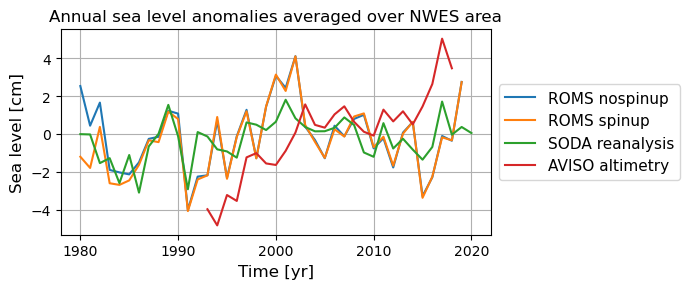

In [115]:
data_lst = [roms_nospinup_zeta, roms_spinup_run4_zeta, soda, aviso_altimetry]
var_lst = ['zeta', 'zeta', 'zos', 'adt']
labels = ['ROMS nospinup', 'ROMS spinup', 'SODA reanalysis', 'AVISO altimetry']

figure_annual_regional_mean(data_lst, var_lst, labels)

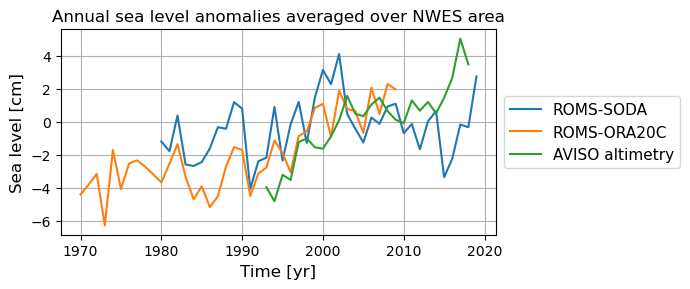

In [117]:
data_lst = [roms_spinup_run4_zeta, roms_ora_zeta, aviso_altimetry]
var_lst = ['zeta', 'zeta', 'adt']
labels = ['ROMS-SODA', 'ROMS-ORA20C', 'AVISO altimetry']

figure_annual_regional_mean(data_lst, var_lst, labels, '_ora')

### Substract value of 1993 to obtain anomalies

In [27]:
def figure_annual_regional_mean(data_lst, var_lst, labels):
    '''
    Function to obtain the weighted regional mean of data and plot this.
    
    data_lst should be a list containing the data that should be plotted
    var_lst should be a list containing the variable names for the sea level variable
    labels should be a list of the data's names for the legend
    
    '''
    
    weights = np.cos(np.deg2rad(data_lst[0].latitude))
    
    data_averaged = []
    for i, data in enumerate(data_lst):
        weighted = data.weighted(weights)                                      # Obtain weights
        averaged = weighted.mean(['latitude', 'longitude'])                    # Obtain area average
        data_averaged.append(averaged[var_lst[i]] - averaged[var_lst[i]].sel(time=1993))   # Obtain anomalies
    
    
    # Plot data
    plt.figure(figsize = (7,3))
    for data in data_averaged:
        plt.plot(data.time, data*100)
        
    fsize = 12
    plt.xlabel('Time [yr]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Annual sea level anomalies averaged over NWES area', fontsize = fsize)
    plt.xticks(range(1980, 2021, 10), fontsize = fsize-2)
    plt.yticks(fontsize = fsize-2)
    plt.grid()
    
    plt.legend(labels = labels, fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    
    
    plt.savefig(f'{path_fig}/annual_regional_mean_anomalies1993')

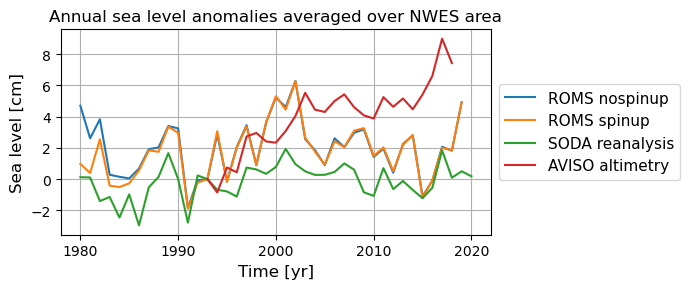

In [28]:
data_lst = [roms_nospinup_zeta, roms_spinup_run4_zeta, soda, aviso_altimetry]
var_lst = ['zeta', 'zeta', 'zos', 'adt']
labels = ['ROMS nospinup', 'ROMS spinup', 'SODA reanalysis', 'AVISO altimetry']

figure_annual_regional_mean(data_lst, var_lst, labels)

## Compare sea level along the Dutch coast

In [29]:
slbudget_2021

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.902359
1951,-3.931027,-3.211249,0.097124,0.00525,0.048333,0.005000,-0.001250,0.290417,0.008253,-1.269401,0.096495,0.702359
1952,1.461333,1.655393,0.176444,0.01050,0.107500,0.010417,-0.002083,0.284167,-0.054336,-0.312677,-0.413991,2.012359
1953,-4.235963,-1.791659,0.177486,0.01575,0.172083,0.015000,-0.001667,0.276667,-0.180699,-0.367838,-2.551085,0.772359
1954,-2.075711,-3.262929,0.193522,0.02100,0.222917,0.020417,-0.002500,0.165833,-0.356571,0.766438,0.156163,1.392359
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,4.848630,0.470808,4.680546,0.34650,2.369583,0.850000,-0.042917,-0.073750,-1.249658,-0.979608,-1.522873,8.854070
2017,8.565807,1.251596,4.838131,0.35175,2.434167,0.865000,-0.042500,-0.545000,-1.196393,1.311972,-0.702915,12.391570
2018,3.803594,0.508159,4.889651,0.35700,2.451250,0.975000,-0.035000,-0.685417,-1.077951,-1.806060,-1.773038,7.110848


In [30]:
compare_budget_2021 = slbudget_2021['LocSteric'] + slbudget_2021['Pressure']
compare_budget_2021 = compare_budget_2021.loc[1980:]/100

compare_budget_2022 = slbudget_2022['LocSteric'] + slbudget_2022['Pressure']
compare_budget_2022 = compare_budget_2022.loc[1980:]/100

In [31]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']

def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/ROMS/data/'
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords = station_coords()


def figure_dutch_coast(data_lst, var_lst, labels):
    '''
    Function to obtain the sea level along the Dutch coast and plot this
    
    data_lst should be a list containing the data that should be plotted
    var_lst should be a list containing the variable names for the sea level variable
    labels should be a list of the data's names for the legend
    '''
    
    
    data_dutchcoast = []
    for i, data in enumerate(data_lst):
        df = pd.DataFrame({'time':data.time.data}).set_index('time')
        for station in stations:
            df[station] = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
            
        df['Average'] = df.mean(axis=1)
        data_dutchcoast.append(df['Average'] - df['Average'].loc[1993:2018].mean())
    
    data_dutchcoast.append(compare_budget_2021 - compare_budget_2021.loc[1993:2018].mean())
    data_dutchcoast.append(compare_budget_2022 - compare_budget_2022.loc[1993:2018].mean())
    
    # Plot data
    plt.figure(figsize = (8,3))
    for data in data_dutchcoast:
        plt.plot(data.index, data*100)
     
    
    fsize = 12
    plt.xlabel('Time [yr]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Annual sea level anomalies along the Dutch coast', fontsize = fsize)
    plt.xticks(range(1980, 2021, 10), fontsize = fsize-2)
    plt.yticks(fontsize = fsize-2)
    plt.grid()
    
    plt.legend(labels = labels + ['Budget 2021\nlocal steric + pressure', 'Budget 2022\nlocal steric + pressure'], fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    
    plt.savefig(f'{path_fig}/sealevel_anomalies_dutchcoast')

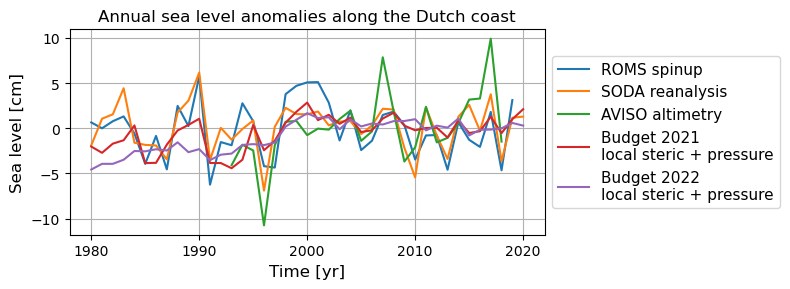

In [32]:
data_lst = [roms_spinup_run4_zeta, soda, aviso_altimetry]
var_lst = ['zeta', 'zos', 'adt']
labels = ['ROMS spinup', 'SODA reanalysis', 'AVISO altimetry']

dt = figure_dutch_coast(data_lst, var_lst, labels)

## Compare sea level near tide gauge stations

In [33]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'West-Terschelling', 'Brest', 'Sheerness', 'Cuxhaven', 'Esbjerg', 'Hirsthals', 'Tregde', 'Stavanger', 'Lerwick', 'Aberdeen', 'North Shields', 'Lowestoft']
  

def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/ROMS/data/'
    
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32, 236, 1, 3, 7, 80, 89, 302, 47, 830, 361, 95, 754]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords = station_coords()



def figure_sea_level_tg_stations(data_lst, var_lst, labels):
    '''
    Function to obtain the sea level near tide gauge stations
    
    data_lst should be a list containing the data that should be plotted
    
    '''
    # Plot data
    fig, axs = plt.subplots(9, 2, figsize=(12, 18))
    fsize = 12
    
    for j in range(9):
    
        
        station = stations[2*j]
        ax = axs[j,0]
        
        data_station = []
        for i, data in enumerate(data_lst):
            if station in ['Vlissingen', 'Den Helder', 'Harlingen', 'Esbjerg']:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
            else:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
            station_data = station_data - station_data.where((station_data.time >= 1993) & (station_data.time <= 2018), drop = True).mean('time')
            data_station.append(station_data)
            
            
        for data in data_station:
            ax.plot(data.time, data*100)
        
        ax.grid()
        ax.set_xlabel('Time [yr]', fontsize = fsize)
        ax.set_ylabel('Sea level [cm]', fontsize = fsize)
        ax.set_title(station, fontsize = fsize)
        ax.set_xticks(range(1980, 2021, 10), fontsize = fsize-2)
        ax.set_yticks([-10, 0, 10], fontsize = fsize-2)
        
        
        
        
        
        station = stations[2*j+1]
        ax = axs[j,1]
        
        data_station = []
        for i, data in enumerate(data_lst):
            if station in ['Hoek v. Holland', 'Brest', 'Cuxhaven', 'Stavanger']:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
            elif station in ['Delfzijl']:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
            elif station in ['Aberdeen']:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]+0.3, method = 'Nearest')
            else:
                station_data = data[var_lst[i]].sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
            station_data = station_data - station_data.where((station_data.time >= 1993) & (station_data.time <= 2018), drop = True).mean('time')
            data_station.append(station_data)
            
            
        for data in data_station:
            ax.plot(data.time, data*100)
        
        ax.grid()
        ax.set_xlabel('Time [yr]', fontsize = fsize)
        ax.set_ylabel('', fontsize = fsize)
        ax.set_title(station, fontsize = fsize)
        ax.set_xticks(range(1980, 2021, 10), fontsize = fsize-2)
        ax.set_yticks([-10, 0, 10], fontsize = fsize-2)
    
    
        
    
    
    axs[0,1].legend(labels = labels, fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    axs[5,1].legend(labels = labels, fontsize = fsize-1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    
    plt.savefig(f'{path_fig}/sealevel_anomalies_tidegauges')

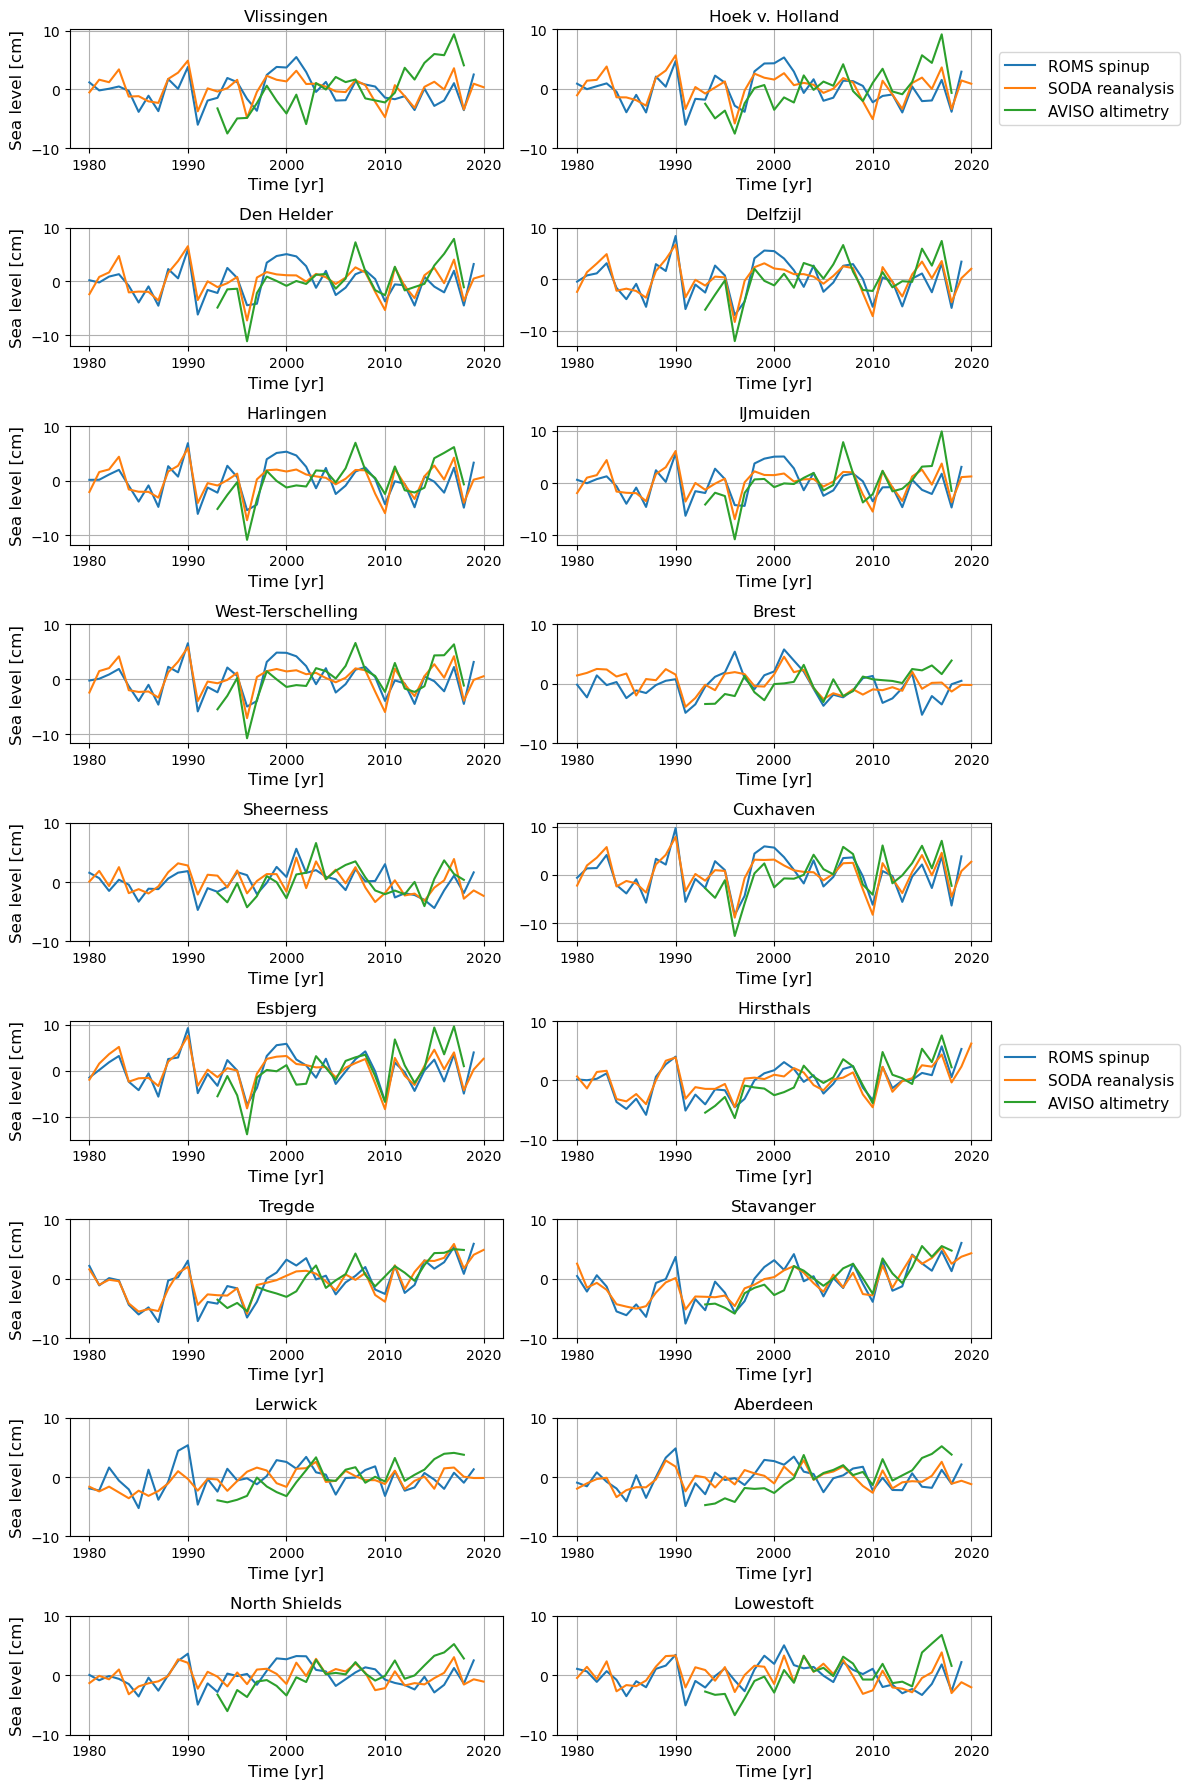

In [34]:
data_lst = [roms_spinup_run4_zeta, soda, aviso_altimetry]
var_lst = ['zeta', 'zos', 'adt']
labels = ['ROMS spinup', 'SODA reanalysis', 'AVISO altimetry']

figure_sea_level_tg_stations(data_lst, var_lst, labels)

## Compare mean dynamic topography (MDT) and standard deviation

### Obtain MDT

Obtain the MDT for ROMS output and SODA reanalysis over reference period 1993 - 2012

In [35]:
# Obtain period from 1993 to 2012 and obtain time average to get MDT
roms_mdt = roms_spinup_run4_zeta.zeta.where((roms_spinup_run4_zeta.time >= 1993) & (roms_spinup_run4_zeta.time <= 2012), drop = True).mean('time')
soda_mdt = soda.zos.where((soda.time >= 1993) & (soda.time <= 2012), drop = True).mean('time')

# Obtain anomalies w.r.t. area-weighted regional mean
weights = np.cos(np.deg2rad(roms_mdt.latitude))
roms_weighted = roms_mdt.weighted(weights)
soda_weighted = soda_mdt.weighted(weights)
cnes_weighted = cnes_mdt.weighted(weights)

# Obtain area mean
roms_area_mean = roms_weighted.mean(['latitude', 'longitude'])
soda_area_mean = soda_weighted.mean(['latitude', 'longitude'])
cnes_mdt_area_mean = cnes_weighted.mean(['latitude', 'longitude'])


# Obtain anomalies
roms_mdt_anomaly = roms_mdt - roms_area_mean
soda_mdt_anomaly = soda_mdt - soda_area_mean
cnes_mdt_anomaly = cnes_mdt.mdt - cnes_mdt_area_mean.mdt

# Convert to cm
roms_mdt_anomaly = roms_mdt_anomaly*100
soda_mdt_anomaly = soda_mdt_anomaly*100
cnes_mdt_anomaly = cnes_mdt_anomaly*100

### Obtain SD

In [36]:
# Obtain period from 1993 to 2012 and obtain time average to get MDT
roms_sd = roms_spinup_run4_zeta.where((roms_spinup_run4_zeta.time >= 1993) & (roms_spinup_run4_zeta.time <= 2012), drop = True)
soda_sd = soda.where((soda.time >= 1993) & (soda.time <= 2012), drop = True)
aviso_sd = aviso_altimetry.where((aviso_altimetry.time >= 1993) & (aviso_altimetry.time <= 2012), drop = True)


# Obtain detrended data
roms_sd = roms_sd.zeta - xr.polyval(roms_sd.time, roms_sd.zeta.polyfit(dim = 'time', deg=3).polyfit_coefficients)
soda_sd = soda_sd.zos - xr.polyval(soda_sd.time, soda_sd.zos.polyfit(dim = 'time', deg=3).polyfit_coefficients)
aviso_sd = aviso_sd.adt - xr.polyval(aviso_sd.time, aviso_sd.adt.polyfit(dim = 'time', deg=3).polyfit_coefficients)

# Obtain standard deviation and convert to cm
roms_sd = roms_sd.std(dim = ['time'])*100
soda_sd = soda_sd.std(dim = ['time'])*100
aviso_sd = aviso_sd.std(dim = ['time'])*100

/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Plot MDT and SD

In [37]:
def figure_mdt_sd():
    '''
    Function to plot the mdt and sd
    
    '''
    
    fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (8, 3*3))
    
    fsize = 13
    
    # Plot MDT
    roms_mdt_anomaly.plot(ax=axes[0,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})
    soda_mdt_anomaly.plot(ax=axes[1,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})
    cnes_mdt_anomaly.plot(ax=axes[2,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})
    
    # Plot SD
    roms_sd.plot(ax = axes[0,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})
    soda_sd.plot(ax = axes[1,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})
    aviso_sd.plot(ax = axes[2,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})
    

    # Add titles
    axes[0,0].set_title('ROMS MDT', fontsize = fsize)
    axes[1,0].set_title('SODA MDT', fontsize = fsize)
    axes[2,0].set_title('CNES MDT', fontsize = fsize)
    axes[0,1].set_title('ROMS SD', fontsize = fsize)
    axes[1,1].set_title('SODA SD', fontsize = fsize)
    axes[2,1].set_title('AVISO SD', fontsize = fsize)


    # Add y-labels
    axes[0,0].set_ylabel('Latitude [°]', fontsize = fsize)
    axes[1,0].set_ylabel('Latitude [°]', fontsize = fsize)
    axes[2,0].set_ylabel('Latitude [°]', fontsize = fsize)

    axes[0,1].set_ylabel('', fontsize = fsize)
    axes[1,1].set_ylabel('', fontsize = fsize)
    axes[2,1].set_ylabel('', fontsize = fsize)


    # Add x-labels
    axes[0,0].set_xlabel('', fontsize = fsize)
    axes[1,0].set_xlabel('', fontsize = fsize)
    axes[2,0].set_xlabel('Longitude [°]', fontsize = fsize)

    axes[0,1].set_xlabel('', fontsize = fsize)
    axes[1,1].set_xlabel('', fontsize = fsize)
    axes[2,1].set_xlabel('Longitude [°]', fontsize = fsize)



    # Change facecolor
    axes[0,0].set_facecolor('lightgray')
    axes[1,0].set_facecolor('lightgray')
    axes[2,0].set_facecolor('lightgray')

    axes[0,1].set_facecolor('lightgray')
    axes[1,1].set_facecolor('lightgray')
    axes[2,1].set_facecolor('lightgray')

    plt.tight_layout()
    
    
    plt.savefig(f'{path_fig}/mdt_sd')

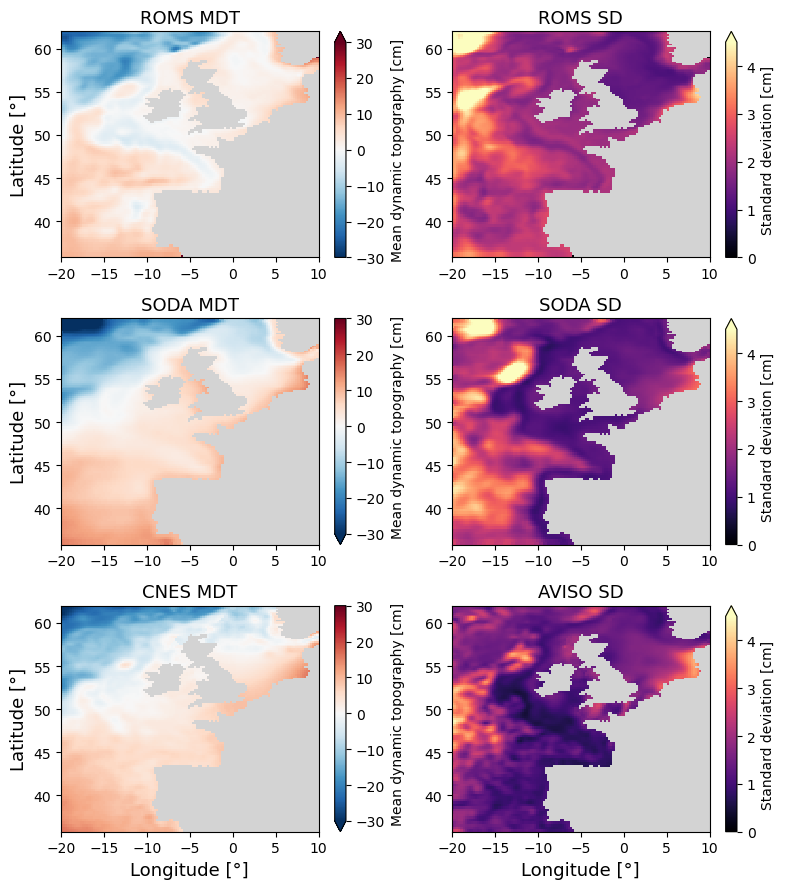

In [38]:
figure_mdt_sd()